In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from scipy.spatial.distance import mahalanobis,euclidean
from sklearn import metrics
from scipy.spatial.distance import mahalanobis
import heapq

# Load data

In [2]:
batch_num = 8
hidden_num = 25
step_num = 10
elem_num = 7
init_wins =10000 

names = [str(x) for x in range(elem_num)] +["label"]
forest = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/forest_cbyc.csv",names=names,skiprows=step_num*init_wins)
classlabel = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/forest_cbyc_classlabel.csv",header=None,skiprows=step_num*init_wins).iloc[:,-1]

batches = forest.shape[0]//step_num//batch_num

test_set = forest.iloc[:batches*batch_num*step_num,:-1]
labels =forest.iloc[:batches*batch_num*step_num,-1]
cls = classlabel.iloc[:batches*batch_num*step_num]
ts = test_set.as_matrix().reshape(batches,batch_num,step_num,elem_num)
test_set_list = [ts[a] for a in range(batches)]
cl_list = [cls.as_matrix().reshape(batches,batch_num,step_num)[a] for a in range(batches)]

In [3]:
labels[labels!="normal"] = "anomaly"

In [4]:
del forest
del test_set

In [5]:
wins = batches * batch_num
# figure out anomaly windows
buffer = [labels[i*step_num:(i+1)*step_num] for i in range(0,labels.size//step_num)]
anomaly_index = []
count = 0
for buf in buffer:
    if "anomaly" in buf.tolist():
        anomaly_index.append(count)
    else:
        pass
    count +=1
print(anomaly_index)

expert = ["normal"]*wins
for x in anomaly_index:
    expert[x] = "anomaly"

[23, 24, 25, 26, 27, 28, 29, 30, 342, 343, 344, 345, 346, 347, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 2357, 2358, 2359, 2428, 2429, 2430, 2431, 2432, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4710, 4711, 4712, 4713, 4714, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973, 5680, 5681, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 6378, 6379, 6380, 6381, 6382, 7973, 7974, 7975, 7976, 9282, 9283, 9284, 9285, 9286, 9287, 9288, 9289, 12743, 12744, 12745, 12746, 12747, 12748, 12749, 12750, 12751, 12752, 12753, 15490, 15491, 15492, 15493, 15494, 15495, 15496, 16454, 16455, 16456, 16457, 17117, 17118, 17119, 17120, 17121, 17122, 17123, 17124, 17125, 17126, 17512, 17513, 17514, 17515, 18812, 18813, 19081, 19082, 19083, 19084, 19085, 19086, 19087, 19120, 19121, 19122, 19123, 19124, 19125, 22647, 22648, 22649, 22650, 22651, 22652, 22653, 22654, 22655, 22874, 22875, 22876, 22877, 26787, 26788, 26789, 27313, 27314, 27315, 27316, 27317, 27318, 27319, 27394, 27395, 27396, 27397, 27398, 27399,

# Load Model

In [6]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/models/forest_cbyc_8_25_10/"
modelmeta_p = modelpath_root + "_8_25_10_para.ckpt.meta"

sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/models/forest_cbyc_8_25_10/_8_25_10_para.ckpt


In [7]:
print(mu.shape,sigma.shape,threshold)

(7,) (7, 7) 0.00818055


# Online Phase (With expert)

In [8]:
def local_preprocessing(batchdata):
    # input batchdata with shape : [batch_num, step_num, elem_num]
    # minmax scaler on window level
    df = pd.DataFrame()
    
    for window in batchdata:
        
        scaler = MinMaxScaler()
        scaler.fit(window)
        new_win = scaler.transform(window)
        df = pd.concat((df, pd.DataFrame(new_win)),axis=0) if df.size!=0 else pd.DataFrame(new_win)
    return df.as_matrix().reshape(batchdata.shape)

    

In [9]:
def scoring(err,mu,sigma):
    
    scores = []
    for e in err:
        scores.append(mahalanobis(e,mu,sigma))

    return scores

In [10]:
def get_musigma(err_nbuf,mu,sigma):       
    
        err_vec_array = np.array(err_nbuf)
        # for multivariate  data
        mu = np.mean(err_vec_array,axis=0)
        sigma = np.cov(err_vec_array.T)
        return mu, sigma

In [11]:
def get_threshold(normal_score, abnormal_score):
        upper = np.median(np.array(abnormal_score))
        lower = np.median(np.array(normal_score)) 
        scala = 20
        delta = (upper-lower) / scala
        candidate = lower
        threshold = 0
        result = 0

        def evaluate(threshold,normal_score,abnormal_score):

            beta = 0.5
            tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
            fp = len(abnormal_score)-tp
            fn = np.array(normal_score)[np.array(normal_score)>threshold].size
            tn = len(normal_score)- fn

            if tp == 0: return 0

            P = tp/(tp+fp)
            R = tp/(tp+fn)
            fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
            return fbeta 

        for _ in range(scala):
            r = evaluate(candidate,normal_score,abnormal_score)
            if r > result:
                result = r 
                threshold = candidate
            candidate += delta 
        return threshold

In [12]:
def plot_roc(fpr,tpr,auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
err_nbuf = []
err_abuf = []
all_scores = []
cl_buf_tmp = []
cl_buf = []
cl_notin_buf_tmp = []
cl_notin_buf = []
start_time = time.time()
for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for ids in range(len(test_set_list)):
#for data in test_set_list:
        data = test_set_list[ids]
        cl = cl_list[ids]
        
        if count % 100 == 0:
            print(count)
            
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
  
        scores = scoring(err,mu,sigma) # (8*30,)
        #scores = pd.Series(scores)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in np.array(scores).reshape(batch_num,step_num)]
        output += [ss.max() for ss in np.array(scores).reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]  # (8,30)
        
        label = [expert[count*batch_num+b] for b in range(batch_num)]
        e = err
        
#       for index,value in enumerate(pd.DataFrame(pred)):
        for i in range(pd.DataFrame(pred).shape[0]):#loop batch_num
            index = i
            value=pd.DataFrame(pred).iloc[i,:]
            
            if value[value>threshold].size>=4: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    cl_buf_tmp += [cl[index,x] for x in range(step_num)]
                    #err_abuf.append(e[index*step_num:(index+1)*step_num])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                else:
                    #print("FP")
                    #err_nbuf.append(e[index])
                    cl_buf_tmp += [cl[index,x] for x in range(step_num)]
                    err_nbuf =np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    
                    n_buf += [df[index,x,:] for x in range(step_num)]
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    cl_buf_tmp += [cl[index,x] for x in range(step_num)]
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    #err_abuf.append(e[index])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                else:
                    cl_notin_buf_tmp += [cl[index,x] for x in range(step_num)]
                    #err_nbuf.append(e[index])
                    err_nbuf = np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    #print("TN")
        count +=1
        
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()
print("--- Initialization time: %s seconds ---" % (time.time() - start_time))

0 : 0 ,  0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


100 : 3440 ,  140
retrain at 118 batch
Parameters updated! new threshold 0.008


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


200 : 300 ,  70
300 : 570 ,  100
400 : 800 ,  150
500 : 1000 ,  150
600 : 1360 ,  280
700 : 1490 ,  360
800 : 1720 ,  510
900 : 2070 ,  510
1000 : 2400 ,  550
1100 : 2630 ,  550
1200 : 2850 ,  630
1300 : 3080 ,  630
1400 : 3370 ,  630
retrain at 1421 batch
Parameters updated! new threshold 0.008
1500 : 1460 ,  0
1600 : 2020 ,  110
1700 : 2600 ,  110
1800 : 3050 ,  110
1900 : 3540 ,  110
retrain at 1987 batch
Parameters updated! new threshold 0.008
2000 : 90 ,  0
2100 : 250 ,  40
2200 : 510 ,  180
2300 : 650 ,  180
2400 : 910 ,  330
2500 : 1060 ,  330
2600 : 1280 ,  330
2700 : 1490 ,  330
2800 : 1770 ,  330
2900 : 1990 ,  460
3000 : 2270 ,  460
3100 : 2770 ,  460
3200 : 3090 ,  460
3300 : 3420 ,  460
3400 : 3710 ,  490
retrain at 3454 batch
Parameters updated! new threshold 0.008
3500 : 40 ,  0
3600 : 130 ,  0
3700 : 240 ,  0
3800 : 330 ,  0
3900 : 440 ,  0
4000 : 510 ,  40
4100 : 560 ,  40
4200 : 670 ,  40
4300 : 730 ,  130
4400 : 780 ,  180
4500 : 840 ,  180
4600 : 900 ,  340
4700 : 9

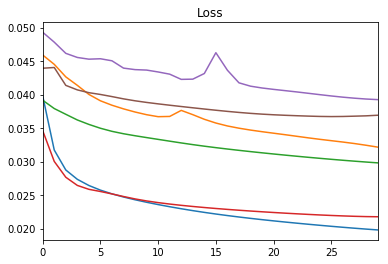

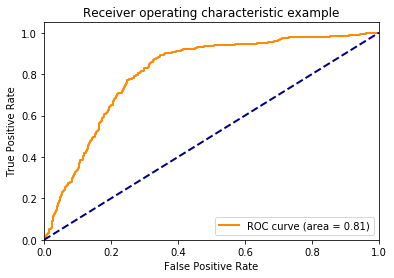

--- Initialization time: 176.02871537208557 seconds ---


In [13]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
err_nbuf = []
err_abuf = []
all_scores = []
cl_buf_tmp = []
cl_buf = []
cl_notin_buf_tmp = []
cl_notin_buf = []
start_time = time.time()
prediction2 = []

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for ids in range(len(test_set_list)):
#for data in test_set_list:
        data = test_set_list[ids]
        cl = cl_list[ids]
        
        if count % 100 == 0:
            print(count,":",len(n_buf),", ",len(a_buf))
            
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
  
        scores = scoring(err,mu,sigma) # (8*30,)
        #scores = pd.Series(scores)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in np.array(scores).reshape(batch_num,step_num)]
        output += [ss.max() for ss in np.array(scores).reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]  # (8,30)
        
        label = [expert[count*batch_num+b] for b in range(batch_num)]
        e = err
        
#       for index,value in enumerate(pd.DataFrame(pred)):
        for i in range(pd.DataFrame(pred).shape[0]):#loop batch_num
            index = i
            value=pd.DataFrame(pred).iloc[i,:]
            
            if value[value>threshold].size>=10: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    cl_buf_tmp += [cl[index,x] for x in range(step_num)]
                    #err_abuf.append(e[index*step_num:(index+1)*step_num])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                    prediction2 +=[1]
                else:
                    #print("FP")
                    #err_nbuf.append(e[index])
                    cl_buf_tmp += [cl[index,x] for x in range(step_num)]
                    err_nbuf =np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    n_buf += [df[index,x,:] for x in range(step_num)]
                    prediction2 +=[2]
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    cl_buf_tmp += [cl[index,x] for x in range(step_num)]
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    #err_abuf.append(e[index])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                    prediction2 += [3]
                else:
                    cl_notin_buf_tmp += [cl[index,x] for x in range(step_num)]
                    #err_nbuf.append(e[index])
                    err_nbuf = np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    prediction2 +=[4]
        count +=1
        
        
        #n_buf = list(np.concatenate(n_buf,axis=0)) if len(n_buf) != 0 else list(n_buf)
        #a_buf = list(np.concatenate(a_buf,axis=0)) if len(a_buf) != 0 else list(a_buf)
        
        if len(n_buf)>=batch_num*step_num*50 and len(a_buf) !=0:
            while (len(a_buf) < batch_num*step_num):
                a_buf += a_buf
            
            B = len(n_buf) //(batch_num*step_num)
            n_buf = n_buf[:batch_num*step_num*B]
            A = len(a_buf)//(batch_num*step_num)
            a_buf = a_buf[:batch_num*step_num*A]
            
            print("retrain at %d batch"%count)
            loss_list_all=[]

            #datalist = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            datalist = np.array(n_buf[:batch_num*step_num*(B-1)]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_n = np.array(n_buf[batch_num*step_num*(B-1):]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_a = np.array(a_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(30):
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            
            #err_nbuf_tmp = np.array(err_nbuf).reshape(-1,elem_num)
            #mu,sigma = get_musigma(err_nbuf_tmp,mu,sigma)   

      

            print("Parameters updated! new threshold %.3f"%threshold)
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
            err_nbuf = []
            err_abuf = []
            cl_buf.append(cl_buf_tmp)
            cl_buf_tmp = []
            cl_notin_buf.append(cl_notin_buf_tmp)
            cl_notin_buf_tmp = []
cl_buf.append(cl_buf_tmp)
cl_notin_buf.append(cl_notin_buf_tmp)

fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()
print("--- Initialization time: %s seconds ---" % (time.time() - start_time))

In [42]:
pd.Series(prediction0).value_counts()

2    37679
4    10120
1      291
3        6
dtype: int64

In [49]:
pd.Series(prediction1).value_counts()

4    27855
2    19944
1      178
3      119
dtype: int64

In [52]:
pd.Series(prediction2).value_counts()

4    35311
2    12488
3      253
1       44
dtype: int64

In [64]:
pd.Series(prediction2)[33200:].value_counts()

4    13806
2     1090
dtype: int64

In [39]:
adaptive_output = output

In [38]:
foo = pd.Series(output[5348:10000])
bar = pd.Series(expert[5348:10000])
print("Total",bar[bar=="anomaly"].shape)
kar = foo[bar=="anomaly"]
print("Right",kar[kar>0.01].shape)

foo = pd.Series(output[10000:24000])
bar = pd.Series(expert[10000:24000])
print("Total",bar[bar=="anomaly"].shape)
kar = foo[bar=="anomaly"]
print("Right",kar[kar>0.01].shape)

foo = pd.Series(output[24000:])
bar = pd.Series(expert[24000:])
print("Total",bar[bar=="anomaly"].shape)
kar = foo[bar=="anomaly"]
print("Right",kar[kar>0.01].shape)

Total (18,)
Right (17,)
Total (241,)
Right (202,)
Total (38,)
Right (22,)


([<matplotlib.patches.Wedge at 0x222665d5400>,
 [Text(-1.08329,0.191013,''), Text(1.08329,-0.191013,'')])

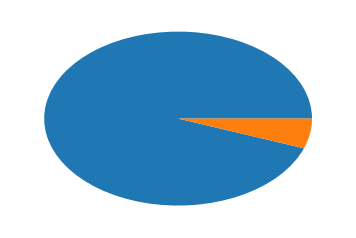

In [44]:
plt.pie([17/18,1/18])


In [ ]:
pd.Series(output).plot()
fpr, tpr, thresholds = metrics.roc_curve(expert[5000:], output[5000:], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
print(auc)

In [ ]:
len(cl_buf)

In [ ]:
for foo in cl_buf:
    print(pd.Series(foo).value_counts())

In [ ]:
for bar in cl_notin_buf:
    print(pd.Series(bar).value_counts())

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(expert[:419*8], output[:419*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(expert[419*8:1295*8], output[419*8:1295*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(expert[1295*8:2265*8], output[1295*8:2265*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(expert[2265*8:], output[2265*8:], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

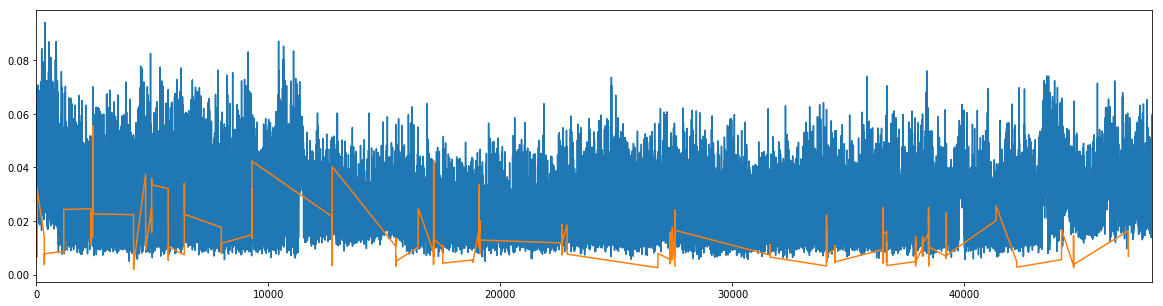

In [14]:

pd.Series(np.array(output)).plot(figsize=(20,5))
pd.Series(np.array(all_scores).ravel())[anomaly_index].plot(figsize=(20,5))

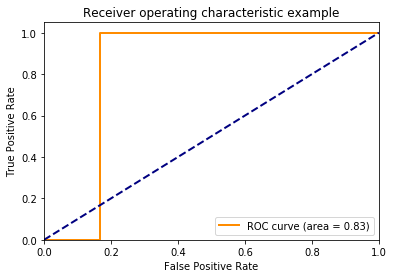

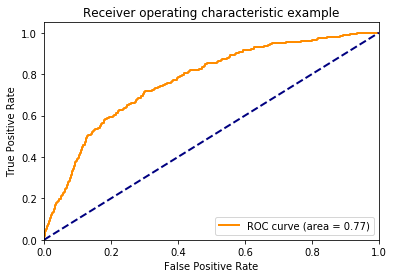

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


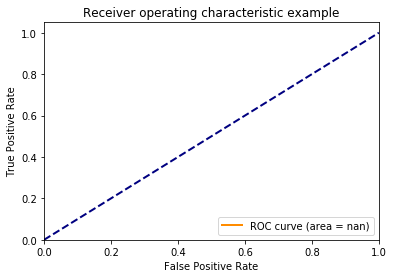

In [22]:
updating_index = [0,1294,1726,2255,2750,3627,4128,6012]
updating_index = [0,1294,4128,6012]

for ui in range(len(updating_index)-1):
    
    fpr, tpr, thresholds = metrics.roc_curve(expert[updating_index[ui]*8:updating_index[ui+1]*8],output[updating_index[ui]*8:updating_index[ui+1]*8], pos_label="anomaly")
    auc = metrics.auc(fpr, tpr)
    #print(fpr,tpr,thresholds,auc)
    plot_roc(fpr,tpr,auc)

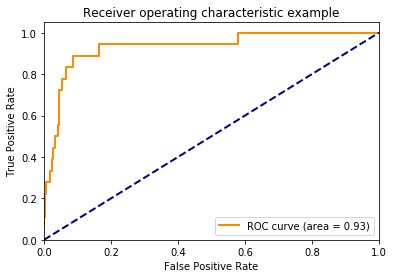

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(expert[5348:10000], output[5348:10000], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

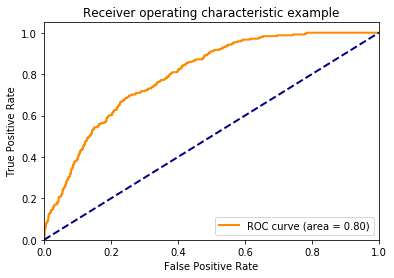

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(expert[10000:24000], output[10000:24000], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

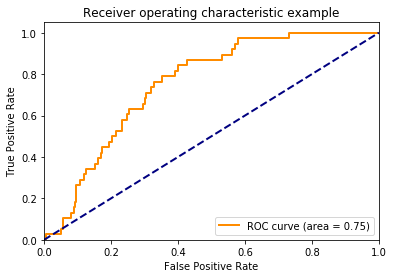

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(expert[24000:], output[24000:], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

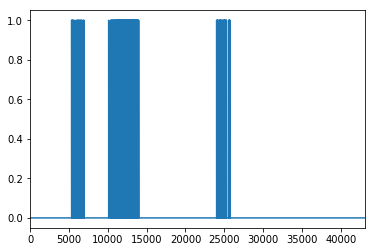

In [30]:
foo = pd.Series(expert)
foo[foo!="normal"] = 1
foo[foo == "normal"] = 0
foo.plot()

In [ ]:

def donutplot(retrain,everseen,p):

    group_names=['N1', 'N2', 'N3',"A",'N4', 'N5', 'N6']
    group_size=everseen
    subgroup_names=['', '', '', '', '', '','', '', '', '', '', '','','']
    subgroup_size=[]
    
    for i in range(len(retrain)):
        subgroup_size += [retrain[i],everseen[i]-retrain[i]]

    # Create colors
    a, b, c,d,e,f,g=[plt.cm.Blues, plt.cm.Greys, plt.cm.Greens, plt.cm.Reds, plt.cm.Greens,plt.cm.Purples,plt.cm.Blues]

    # First Ring (outside)
    fig, ax = plt.subplots()
    ax.axis('equal')
    mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6), c(0.3),d(1.0),e(0.6),f(0.6),g(0.9)] )
    plt.setp( mypie, width=0.3, edgecolor='white')

    # Second Ring (Inside)
    if p != 0:
        mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.6), a(0), b(0.6), b(0), c(0.3), c(0),d(1.0),d(0),e(0.6),e(0),f(0.6),f(0),g(0.9),g(0)])
        plt.setp( mypie2, width=0.4, edgecolor='white')
        plt.margins(0,0)
    else:
        mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0), a(0), b(0), b(0), c(0), c(0),d(0),d(0),e(0),e(0),f(0),f(0),g(0),g(0)])
        plt.setp( mypie2, width=0.4, edgecolor='white')
        plt.margins(0,0)
    # show it
    plt.show()

In [ ]:

streamfragsize =[[13259, 35685, 2160, 2160, 2416, 2160, 2160] ] # initialization set statistic
retrain_stat = [[13259, 35685, 2160, 2160, 2416, 2160, 2160]]
classlabel_online = classlabel

retrain_pos = [0,4190,13570,26570,40950]

for i in range(len(retrain_pos)-1):
    a = retrain_pos[i]
    b = retrain_pos[i+1]
    df = classlabel_online[a:b].value_counts()
    for tmp in range(7):
        if tmp+1 not in df:
            df[tmp+1] = 0
    streamfragsize.append([df[k+1] for k in range(7)])

for vv in cl_buf:
    retrain_stat.append([pd.Series(vv[i+1]).value_counts() for i in range(7)])

for i in range(len(retrain_stat)):
    everseen = streamfragsize[i]

    retrain_ = retrain_stat[i]
    donutplot(retrain_,everseen,i)

# Without retraining

In [ ]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
err_nbuf = []
err_abuf = []
all_scores = []

start_time = time.time()
for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
            
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
  
        scores = scoring(err,mu,sigma)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in np.array(scores).reshape(batch_num,step_num)]
        output += [ss.max() for ss in np.array(scores).reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]  # (8,30)
        
        label = [expert[count*batch_num+b] for b in range(batch_num)]
        e = err
 
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()
print("--- Initialization time: %s seconds ---" % (time.time() - start_time))

In [ ]:

pd.Series(output).plot(figsize=(20,5))
pd.Series(output)[anomaly_index].plot()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(expert[:419*8], output[:419*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(expert[419*8:1295*8], output[419*8:1295*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(expert[1295*8:2265*8], output[1295*8:2265*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(expert[2265*8:], output[2265*8:], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)